In [1]:
!pip install pandas

In [2]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

2025-10-15 15:11:51.905721: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-15 15:11:51.929171: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 15:11:51.929185: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 15:11:51.929205: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 15:11:51.933727: I tensorflow/core/platform/cpu_feature_g

                         value
timestamp                     
2013-07-04 00:00:00  69.880835
2013-07-04 01:00:00  71.220227
2013-07-04 02:00:00  70.877805
2013-07-04 03:00:00  68.959400
2013-07-04 04:00:00  69.283551
...                        ...
2014-05-28 11:00:00  72.370206
2014-05-28 12:00:00  72.172956
2014-05-28 13:00:00  72.046565
2014-05-28 14:00:00  71.825226
2014-05-28 15:00:00  72.584089

[7267 rows x 1 columns]
(7267, 1)


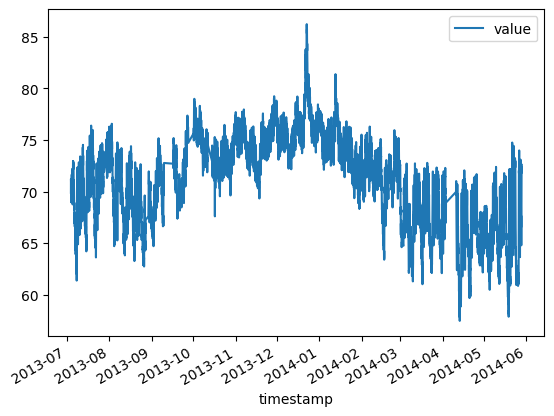

In [3]:
# Cargar los datos
df = pd.read_csv("datos.csv",index_col=0,parse_dates=True)

print(df)
print(df.shape) # (7267,1) (según el fichero cambiará el número de filas)

df.plot()
plt.show()

## Creación de ventanas temporales

In [16]:
# Crear las ventanas temporales
# Lo que se predice (y) es el "siguiente" valor de la secuencia
# pasando la ventana actual que tenemos.
window_size = 5

# sacar array de valores temperatura y predict
raw_temp = df["value"].values
windows = np.lib.stride_tricks.sliding_window_view(raw_temp, window_shape=window_size)

X = array(windows[:-1])
y = array(raw_temp[window_size:])
print(X)
print(y)

X = X.reshape((X.shape[0], X.shape[1],n_features))

[[69.88083514 71.22022706 70.87780496 68.95939994 69.28355102]
 [71.22022706 70.87780496 68.95939994 69.28355102 70.06096581]
 [70.87780496 68.95939994 69.28355102 70.06096581 69.27976479]
 ...
 [67.47256826 68.03307954 70.45571697 72.37020644 72.17295622]
 [68.03307954 70.45571697 72.37020644 72.17295622 72.04656545]
 [70.45571697 72.37020644 72.17295622 72.04656545 71.82522648]]
[70.06096581 69.27976479 69.36960846 ... 72.04656545 71.82522648
 72.58408858]


In [5]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1],n_features))

# define model
model = Sequential()
model.add(Input(shape=(window_size, n_features)))
#model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200)

Epoch 1/200


2025-10-15 15:11:53.071516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: UNKNOWN ERROR (34)


227/227 [==============================] - 1s 949us/step - loss: 636.2423
Epoch 2/200
227/227 [==============================] - 0s 919us/step - loss: 1.7334
Epoch 3/200
227/227 [==============================] - 0s 914us/step - loss: 1.6488
Epoch 4/200
227/227 [==============================] - 0s 920us/step - loss: 1.3564
Epoch 5/200
227/227 [==============================] - 0s 892us/step - loss: 1.1065
Epoch 6/200
227/227 [==============================] - 0s 888us/step - loss: 1.0479
Epoch 7/200
227/227 [==============================] - 0s 901us/step - loss: 0.9989
Epoch 8/200
227/227 [==============================] - 0s 898us/step - loss: 0.9844
Epoch 9/200
227/227 [==============================] - 0s 918us/step - loss: 0.9680
Epoch 10/200
227/227 [==============================] - 0s 897us/step - loss: 0.9509
Epoch 11/200
227/227 [==============================] - 0s 910us/step - loss: 1.0068
Epoch 12/200
227/227 [==============================] - 0s 923us/step - loss: 0.8953

In [22]:
dfTest = df
y_predicts = model.predict(X, verbose=0)
full_predict = np.concatenate([np.full(window_size,np.nan), y_predicts.flatten()])

dfTest["predict"] = full_predict
dfTest["error"] = ((dfTest['value'] - dfTest['predict'])**2)
errorMedio = np.mean((dfTest["value"]-dfTest["predict"])**2)
print("Error medio:",errorMedio)
dfTest

Error medio: 0.7686187728391279


,value,predict,error
timestamp,,,
2013-07-04 00:00:00,69.880835,NaN,NaN
2013-07-04 01:00:00,71.220227,NaN,NaN
2013-07-04 02:00:00,70.877805,NaN,NaN
2013-07-04 03:00:00,68.959400,NaN,NaN
2013-07-04 04:00:00,69.283551,NaN,NaN
...,...,...,...
2014-05-28 11:00:00,72.370206,70.281219,4.363867
2014-05-28 12:00:00,72.172956,72.364288,0.036608
2014-05-28 13:00:00,72.046565,72.631950,0.342676


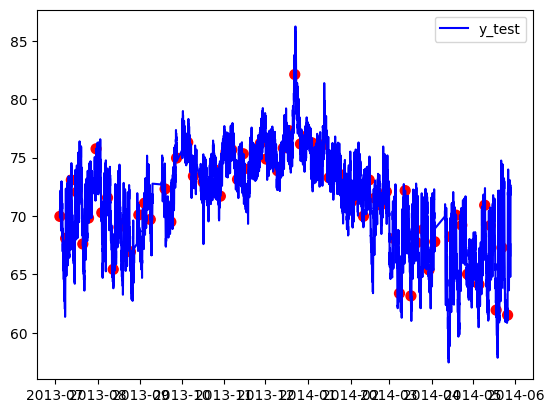

In [7]:
# Dividir los datos en entrenamiento y prueba es lo habitual
# Aunque en este caso, vamos a querer luego detectar anomalías en todos los datos

# Redimensionar los datos para la RNN
# LSTM espera 3 dimensiones: número muestras, pasos temporales, número features
# P.ej: (5805,10,1)

# Crear la RNN

# Entrenar la RNN

# Un posible criterio de anomalía
# Calcular el error absoluto medio (MAE) de los "siguientes" valores de cada secuencia y los valores predichos
# Calcular el promedio del MAE
# mae = np.mean(mae)

# Otro posible criterio: uso de percentiles. Valores que superen un percentil determinado

# Mostrar las fechas de las anomalías
# las anomalias se refieren a las ventanas, no a filas específicas dentro de la ventana

# Mostrar la gráfica con las anomalías
windows_size=10

fechas_test=df[windows_size:].index.to_numpy() # aquí tengo array con fechas de los datos de test

# Anomalías de ejemplo
anomalies = np.array([True if i % 100 == 0 else False for i in range(len(fechas_test))], dtype=bool)

# Opcion 1
y_test=df["value"][windows_size:]
plt.plot(fechas_test,y_test,color='blue',label='y_test')
# los valores de anomalias en el array anomalies se refieren a las ventanas, no a "y"
# aunque hay el mismo numero de ventanas que de valores
plt.scatter(x=fechas_test, y=y_test, c='red', alpha=anomalies.astype(int),s=50)
plt.legend()
plt.show()

# Opcion 2
# fechas_test = df.drop(df.index[:windows_size]) # Eliminar las primeras filas
#                                     # para que coincida con numero de ventanas y poder mostrar grafica
# plt.plot(fechas_test.index, fechas_test["value"], label='Valores', color='blue')  # Columna de tiempo
# plt.scatter(fechas_test.index[anomalies == True], fechas_test["value"][anomalies == True], c='r', label='Anomalía')

# plt.legend()
# plt.show()